## Missing Data and Imputation
Missing data is one of the most prevalent problems when you’re dealing with data, and it can be a particularly problematic one when you’re trying to fit models or extract meaningful information from the data. This demonstration will (a) simulate data missingness that is **Missing at Random (MAR)** and (b) illustrate how to address this type of data missingness.

As discussed in class, there’s nothing to do when data is **Missing Not at Random (MNAR)** because the probability of missingness is conditional on observed and unobserved data. Data that is **Missing Completely at Random (MCAR)** is imputable because the missingness follows the exact same conditional distributions as the observed data, and that makes it a not very interesting case. But data that is **Missing at Random (MAR)** where the probability of missingness depends only on observed data is an interesting and tractable one.

### Missing Data
Let start with a sample dataset, the [Boston Housing dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/) in the ```scikit-learn``` package. The dataset does not have any missing data. For illustration purposes, we will impose some **MAR** missingness and then apply some imputation techniques to show how well we can recover the original distributions.



**Note**: Please install the ```missingno``` library using the command
```!pip install missingno```.

In [ ]:
!pip install missingno

In [1]:
# load all packages that will be needed
import pandas as pd
import numpy as np
import sklearn
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge



#visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Boston Housing dataset
from sklearn import datasets
boston = datasets.load_boston()

In [3]:
type(boston) #Bunch
from sklearn.utils import Bunch

In [4]:
boston['data']

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [5]:
boston['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [6]:
#Load data into a dataframe
df = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


### Simulate Missingness

As you can see, the Boston Housing dataset has no missingness.

In [7]:
#No missing values
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [8]:
#Keep the original data
MAR_BostonHousing = df.copy()

Now, we can proceed to create some data missingness that is conditional on observed values in the same dataset for a couple of variables.

In [9]:
# A function for MAR
import random

def MAR_fun(var1, var2, prop):
    #introduce random noise
    random.seed(9348)
    noise = var1 + np.random.normal(0.0, 0.5, len(var1))
    #pattern of missingness
    pattern = np.repeat(0, len(var1))
    #Set a cut-off value
    cutoff = np.quantile(noise, prop)
    pattern[noise < cutoff] = 1
    var2[pattern == 0] = np.nan
    return var2



First, we impose missingness on ```dis``` (weighted distances to five Boston employment centres) conditional on ```age``` (proportion of owner-occupied units built prior to 1940).

In [10]:
MAR_BostonHousing['DIS'] = MAR_fun(MAR_BostonHousing['AGE'], MAR_BostonHousing['DIS'], 0.85)

In [11]:
#Since Matplotlib does not plot missing values, we would have to create a function that fills dummy variables into
#the null values of the dataframe

from numpy.random import rand

def fill_dummy_values(df, scaling_factor):
    #create copy of dataframe
    df_dummy = df.copy(deep = True)
    # Iterate over each column
    for col in df_dummy:
        
        #get column, column missing values and range
        col = df_dummy[col]
        col_null = col.isnull()
        num_nulls = col_null.sum()
        col_range = col.max() - col.min()
        
        #Shift and scale dummy values
        dummy_values = (rand(num_nulls) - 2)
        dummy_values = dummy_values * scaling_factor * col_range + col.min()
        
        #Return dummy values
        col[col_null] = dummy_values
    return df_dummy


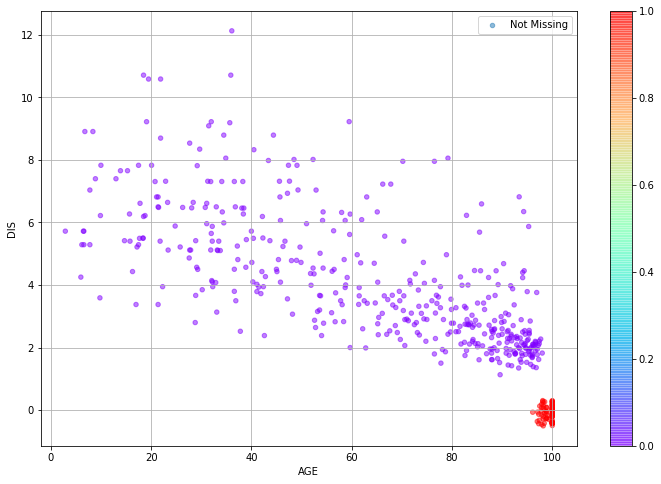

In [12]:
#create dummy dataframe to fill null values with dummy variables
MAR_BH_dummy = fill_dummy_values(MAR_BostonHousing, 0.075)

#Get missing values for coloring
nullity = MAR_BostonHousing['DIS'].isnull()

#Generate Scatter plot
fig, ax = plt.subplots()
MAR_BH_dummy.plot(x = 'AGE', y = 'DIS', kind = 'scatter', alpha = 0.5, c = nullity, cmap = 'rainbow', figsize=(12,8), grid = True, legend = True, ax = ax)
ax.legend(['Not Missing'])


Then, we impose missingness on ```nox``` (nitric oxides concentration) conditional on tax (full-value property-tax rate per $10,000).

In [13]:
MAR_BostonHousing['NOX'] = MAR_fun(MAR_BostonHousing['TAX'], MAR_BostonHousing['NOX'], 0.90)

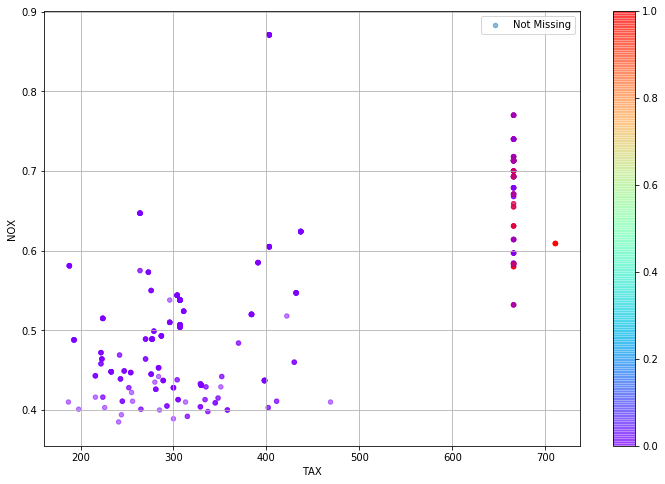

In [14]:
#Get missing values for coloring
nullity_2 = MAR_BostonHousing['NOX'].isnull()

#Generate Scatter plot
fig, ax = plt.subplots()
MAR_BH_dummy.plot(x = 'TAX', y = 'NOX', kind = 'scatter', alpha = 0.5, c = nullity_2, cmap = 'rainbow', figsize=(12,8), grid = True, legend = True, ax = ax)
ax.legend(['Not Missing'])

### Missing Data Imputation
This is not usually the case, but we know that missingess only depends on observed values in the dataset, so **MAR** is the appropriate assumption. In real cases, it is mostly an assumption based on some theoretical elaboration based on expert knowledge about the dataset.

Since we know we can use information in the dataset to “complete” our dataset, we can illustrate some common techniques to do it.

#### Mean Imputation

It is rather common that people spend little time thinking about the most appropriate imputation method to use. It is not unusual that missing values are imputed with the mean value for that variable. It is very common because it will not alter the mean value of the variable. It is probably not a very good alternative because, depending on the missingness in this variable, it will tend to shrink variability towards the mean. It is also possible that a better imputation (possible different from an unconditional mean) can be achieved with methods that take more information into consideration to produce plausible values for this variable.

In [15]:
mean_MAR_BH = MAR_BostonHousing.copy()
mean_MAR_BH['DIS'].fillna(mean_MAR_BH['DIS'].mean(), inplace = True) #replace missing values with the mean
mean_MAR_BH['NOX'].fillna(mean_MAR_BH['NOX'].mean(), inplace = True) #replace missing values with the mean

### Multiple Imputation with Chained Equations (MICE)

A more robust alternative that takes more information into consideration is one done through chained equations. This is an iterative process that starts by assigning start values to all missing data, then picks a variable and uses all other variables to predict its missing values and iterates until the imputations converge to a joint distribution. The chained equations approach is flexible because it allows for different predictors and models to be used for different variables.

In addition, multiple imputation produces ```m < 1``` datasets that preserve the original data but contain plausible values for each missing value from the predictive posterior distribution. This characteristic alone, incorporates our uncertainty about the missing values and can allow us to estimate variances more appropriately.





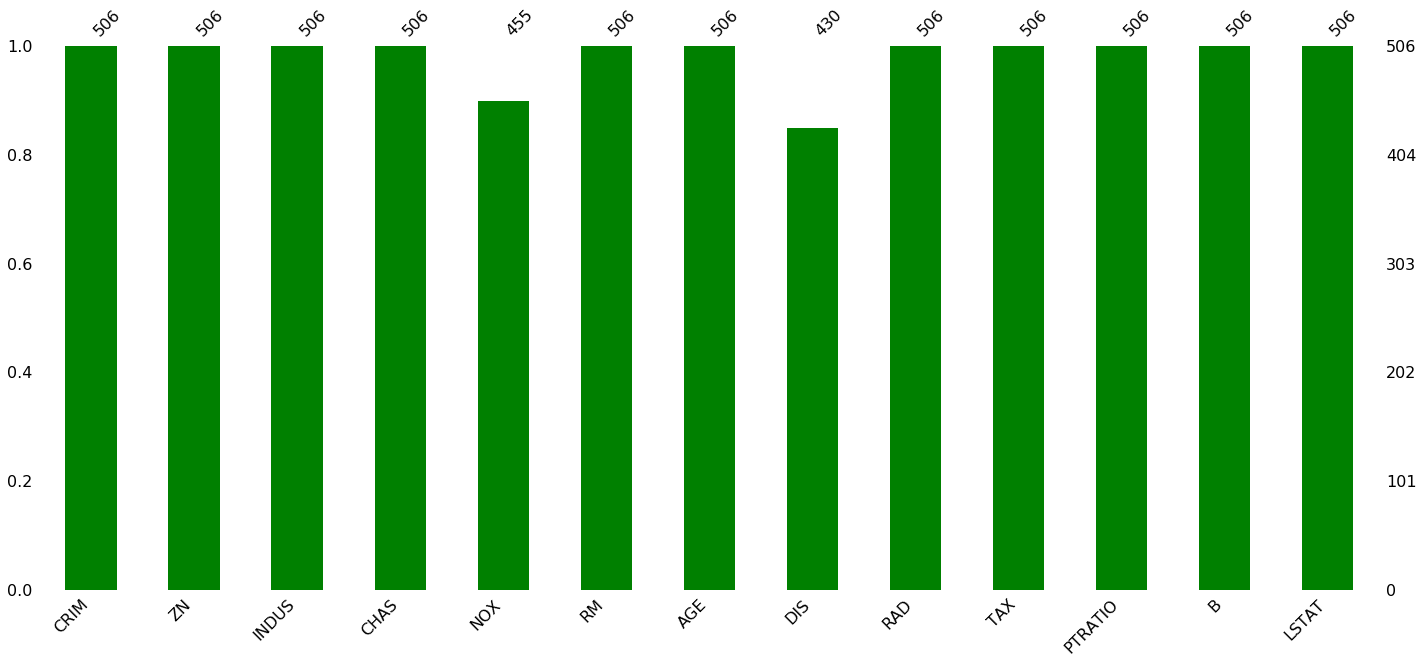

In [16]:
mice_MAR_BH = MAR_BostonHousing.copy()
msno.bar(mice_MAR_BH, color = 'green') #bar plot

In [17]:
mice_MAR_BH.isnull().sum()

CRIM        0
ZN          0
INDUS       0
CHAS        0
NOX        51
RM          0
AGE         0
DIS        76
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT       0
dtype: int64

We use the missingno package here. Note from above that msno.bar() function returns a bar chart with missingness pattern. We learn that there are 404 observations with no missing values. 51 observations have missingness in ```dis```, 26 observations have missingness on ```nox```, and 25 observations have missing values both in ```dis``` and ```nox```.

In [18]:
#use BayesianRidge as estimator
imputer_bayes = IterativeImputer(estimator = BayesianRidge(n_iter=5), sample_posterior = True, max_iter = 100, random_state = 0)
mice_MAR_BH_filled = imputer_bayes.fit_transform(mice_MAR_BH)

#Check missing values
np.isnan(mice_MAR_BH_filled).sum()

0

In [19]:
#Dataframe with the imputed values
mice_MAR_BH = pd.DataFrame(np.reshape(mice_MAR_BH_filled, (506, 13)), columns = boston['feature_names'])
mice_MAR_BH

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


#### Iteration

It is always a good idea to check the imputations visually. The density plots below compare the density of observed data with imputed data. We would expect them to be similar, because missingness is MAR. In this case, you can see that imputations for ```dis``` are relatively close, but those for ```nox``` are not so good.

In [20]:
observed = MAR_BostonHousing.copy()
observed['Imputed'] = np.repeat('observed', 506)

In [21]:
mice_MAR_BH_dis = mice_MAR_BH.copy()
mice_imputed_dis = mice_MAR_BH_dis[MAR_BostonHousing['DIS'].isna()]
mice_imputed_dis['Imputed'] = np.repeat('imputed', 76)

/Users/annamontserratguerrero/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
mice_MAR_BH_nox = mice_MAR_BH.copy()
mice_imputed_nox = mice_MAR_BH_nox[MAR_BostonHousing['NOX'].isna()]
mice_imputed_nox['Imputed'] = np.repeat('imputed', 51)

/Users/annamontserratguerrero/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


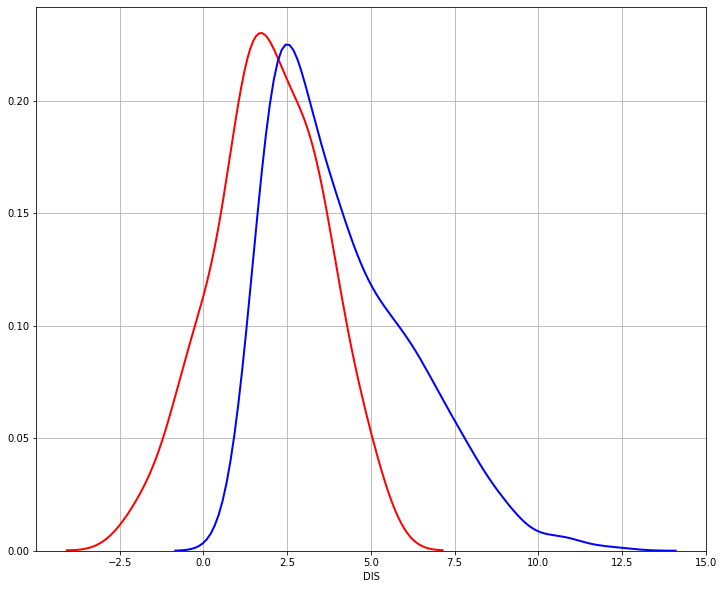

In [50]:
#check density plots
graph_1 = pd.concat([observed, mice_imputed_dis])


graph_1_imputed = graph_1.loc[graph_1['Imputed'] == 'imputed']
graph_1_observed = graph_1.loc[graph_1['Imputed'] == 'observed']


plt.figure(figsize = (12,10))
sns.distplot(graph_1_imputed['DIS'], hist = False, kde = True,
             color = 'red', 
             kde_kws={'linewidth': 2})
sns.distplot(graph_1_observed['DIS'], hist = False, kde = True,
             color = 'blue', 
             kde_kws={'linewidth': 2})
plt.grid()


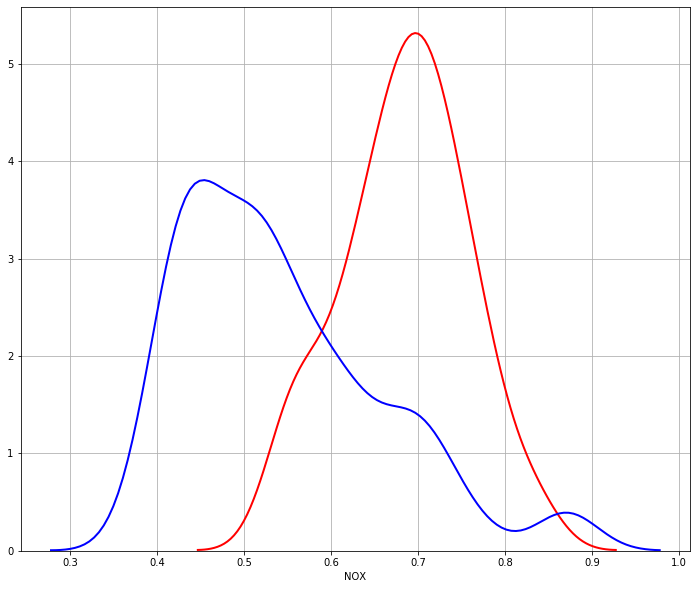

In [51]:
graph_2 = pd.concat([observed, mice_imputed_nox])


graph_2_imputed = graph_2.loc[graph_2['Imputed'] == 'imputed']
graph_2_observed = graph_2.loc[graph_2['Imputed'] == 'observed']


plt.figure(figsize = (12,10))
sns.distplot(graph_2_imputed['NOX'], hist = False, kde = True,
             color = 'red', 
             kde_kws={'linewidth': 2})
sns.distplot(graph_2_observed['NOX'], hist = False, kde = True,
             color = 'blue', 
             kde_kws={'linewidth': 2})
plt.grid()

### KNN Imputation

KNN can be used for missing data imputation. It is close in spirit to “hot deck” or “cold deck” imputation where the closest value - under some metric - is assigned as an imputed missing value.

In [25]:
knn_MAR_BH = MAR_BostonHousing.copy()
imputer = KNNImputer(n_neighbors=10)

#fill missing values by imputing
knn_MAR_BH_filled = imputer.fit_transform(knn_MAR_BH)
#no missing values
np.isnan(knn_MAR_BH_filled).sum()

0

In [26]:
knn_MAR_BH.shape

(506, 13)

In [27]:
#Dataframe with the imputed values
knn_MAR_BH = pd.DataFrame(np.reshape(knn_MAR_BH_filled, (506, 13)), columns = boston['feature_names'])

Check the density plots for knn observed vs. only imputed values

In [28]:
observed = MAR_BostonHousing.copy()
observed['Imputed'] = np.repeat('observed', 506)

In [29]:
knn_MAR_BH_dis = knn_MAR_BH.copy()
knn_imputed_dis = knn_MAR_BH_dis[MAR_BostonHousing['DIS'].isna()]
knn_imputed_dis['Imputed'] = np.repeat('imputed', 76)


/Users/annamontserratguerrero/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
knn_MAR_BH_nox = knn_MAR_BH.copy()
knn_imputed_nox = knn_MAR_BH_nox[MAR_BostonHousing['NOX'].isna()]
knn_imputed_nox['Imputed'] = np.repeat('imputed', 51)


/Users/annamontserratguerrero/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


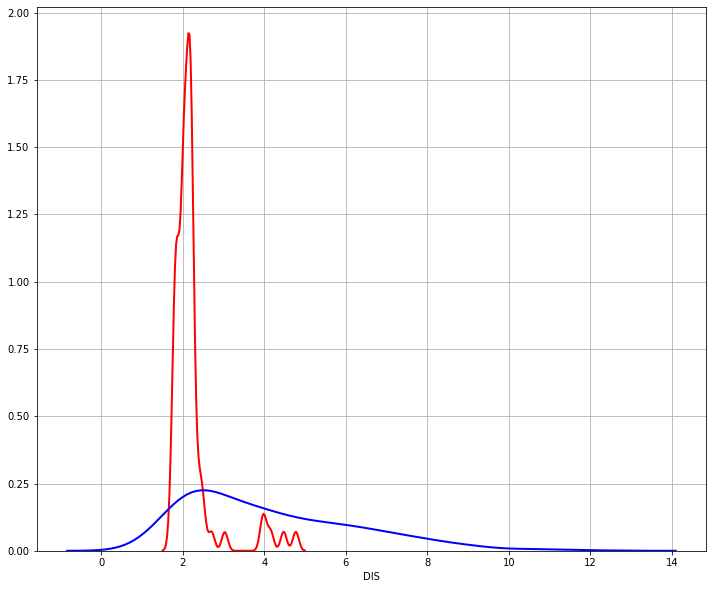

In [52]:
graph_3 = pd.concat([observed, knn_imputed_dis])


graph_3_imputed = graph_3.loc[graph_3['Imputed'] == 'imputed']
graph_3_observed = graph_3.loc[graph_3['Imputed'] == 'observed']


plt.figure(figsize = (12,10))
sns.distplot(graph_3_imputed['DIS'], hist = False, kde = True,
             color = 'red', 
             kde_kws={'linewidth': 2})
sns.distplot(graph_3_observed['DIS'], hist = False, kde = True,
             color = 'blue', 
             kde_kws={'linewidth': 2})
plt.grid()

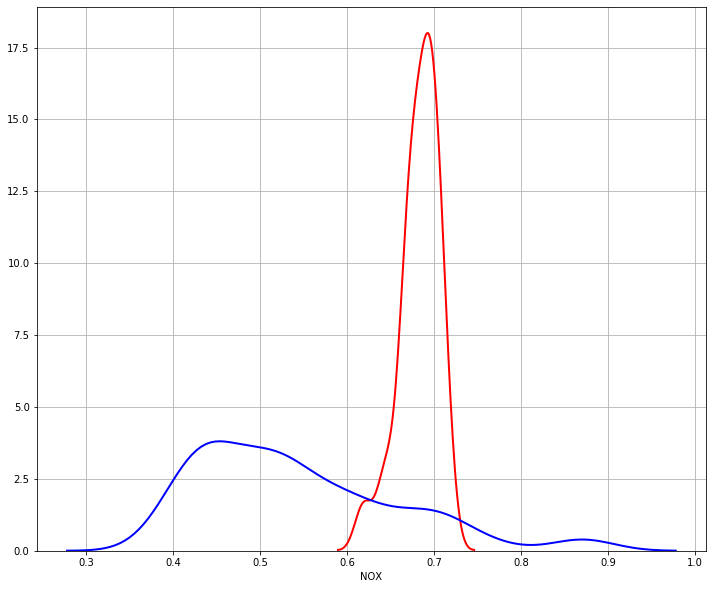

In [53]:
graph_4 = pd.concat([observed, knn_imputed_nox])


graph_4_imputed = graph_4.loc[graph_4['Imputed'] == 'imputed']
graph_4_observed = graph_4.loc[graph_4['Imputed'] == 'observed']


plt.figure(figsize = (12,10))
sns.distplot(graph_4_imputed['NOX'], hist = False, kde = True,
             color = 'red', 
             kde_kws={'linewidth': 2})
sns.distplot(graph_4_observed['NOX'], hist = False, kde = True,
             color = 'blue', 
             kde_kws={'linewidth': 2})
plt.grid()

#### Random Forest Imputation

Another imputation method that can handle non-linearities and deep interactions between variables, that may help get better recover the original distribution under **MAR** is Random Forests. Its application is straightforward under the `missForest` package.

In [33]:
rf_MAR = MAR_BostonHousing.copy()

imputer_missForest = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state =0), max_iter=50, random_state = 0)

#X_train, X_test, y_train, y_test = train_test_split(rf_MAR)
imputer_missForest.fit(rf_MAR)
rf_MAR_filled = imputer_missForest.transform(rf_MAR)
rf_MAR_filled

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [34]:
rf_MAR_BH = pd.DataFrame(np.reshape(rf_MAR_filled, (506, 13)), columns = boston['feature_names'])

In [35]:
rf_MAR_BH #imputed data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


Check the density plots for Random Forest

In [36]:
observed = MAR_BostonHousing.copy()
observed['Imputed'] = np.repeat('observed', 506)

In [37]:
rf_MAR_BH_dis = rf_MAR_BH.copy()
rf_imputed_dis = rf_MAR_BH_dis[MAR_BostonHousing['DIS'].isna()]

rf_imputed_dis['Imputed'] = np.repeat('imputed', 76)

/Users/annamontserratguerrero/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [38]:
rf_MAR_BH_nox = rf_MAR_BH.copy()
rf_imputed_nox = rf_MAR_BH_nox[MAR_BostonHousing['NOX'].isna()]
rf_imputed_nox['Imputed'] = np.repeat('imputed', 51)

/Users/annamontserratguerrero/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


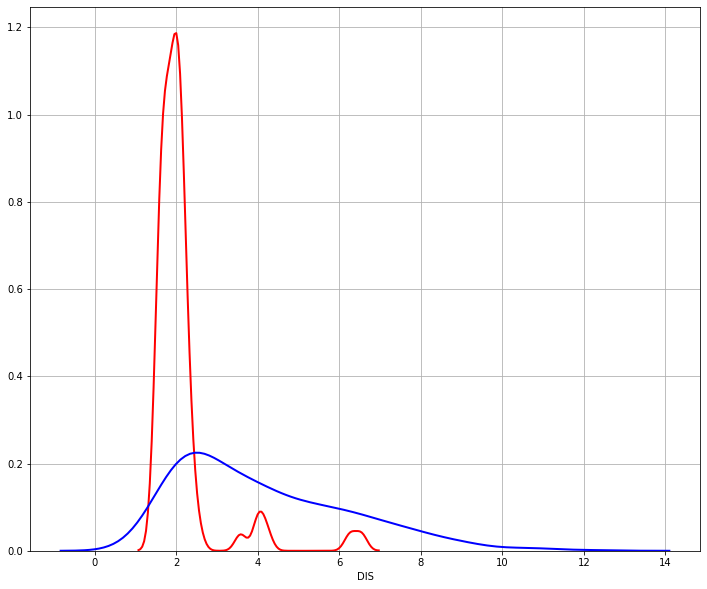

In [54]:
graph_5 = pd.concat([observed, rf_imputed_dis])


graph_5_imputed = graph_5.loc[graph_3['Imputed'] == 'imputed']
graph_5_observed = graph_5.loc[graph_3['Imputed'] == 'observed']


plt.figure(figsize = (12,10))
sns.distplot(graph_5_imputed['DIS'], hist = False, kde = True,
             color = 'red', 
             kde_kws={'linewidth': 2})
sns.distplot(graph_5_observed['DIS'], hist = False, kde = True,
             color = 'blue', 
             kde_kws={'linewidth': 2})
plt.grid()

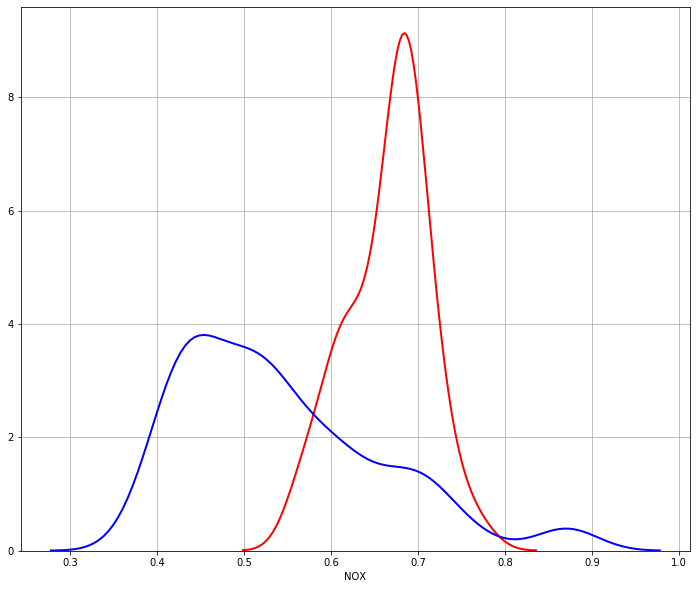

In [55]:
graph_6 = pd.concat([observed, rf_imputed_nox])


graph_6_imputed = graph_6.loc[graph_2['Imputed'] == 'imputed']
graph_6_observed = graph_6.loc[graph_2['Imputed'] == 'observed']


plt.figure(figsize = (12,10))
sns.distplot(graph_6_imputed['NOX'], hist = False, kde = True,
             color = 'red', 
             kde_kws={'linewidth': 2})
sns.distplot(graph_6_observed['NOX'], hist = False, kde = True,
             color = 'blue', 
             kde_kws={'linewidth': 2})
plt.grid()

### An assessment
It is not typically the case that we would have means to assess how good an imputation is. In this example, we can actually get a sense of how good each method was for recovering the original values.

Please note that these assessments are applicable to this example, and are not a comment on which method is generally better than others.

In [41]:
# :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
# ::::::::: GET IMPUTATION METRICS FOR ALL METHODS ::::::::::::::::::::::::::::

#Functions for accuracy metrics:
def MAE(predict, target):
    return (abs(predict-target)).mean()

def MSE(predict, target):
    return ((predict-target)**2).mean()

def RMSE(predict, target):
    return np.sqrt(((predict - target) ** 2).mean())

def MAPE(predict,target):
    return ( abs((target - predict) / target).mean())

# ::::::::: MEAN IMPUTATION METRICS
# Get an accuracy metric for the imputation of dis
real_values = df['DIS'][MAR_BostonHousing['DIS'].isna()]
imputed_values = mean_MAR_BH['DIS'][MAR_BostonHousing['DIS'].isna()]
ac_mean_dis_MAE = MAE(imputed_values, real_values)
ac_mean_dis_MSE = MSE(imputed_values, real_values)
ac_mean_dis_RMSE = RMSE(imputed_values, real_values)
ac_mean_dis_MAPE = MAPE(imputed_values, real_values)

# Get an accuracy metric for the imputation  of nox
real_values = df['NOX'][MAR_BostonHousing['NOX'].isna()]
imputed_values = mean_MAR_BH['NOX'][MAR_BostonHousing['NOX'].isna()]
ac_mean_nox_MAE = MAE(imputed_values, real_values)
ac_mean_nox_MSE = MSE(imputed_values, real_values)
ac_mean_nox_RMSE = RMSE(imputed_values, real_values)
ac_mean_nox_MAPE = MAPE(imputed_values, real_values)


# ::::::::: MICE METRICS
# Get an accuracy metric for the imputation of dis
real_values = df['DIS'][MAR_BostonHousing['DIS'].isna()]
imputed_values = mice_MAR_BH['DIS'][MAR_BostonHousing['DIS'].isna()]
ac_mice_dis_MAE = MAE(imputed_values, real_values)
ac_mice_dis_MSE = MSE(imputed_values, real_values)
ac_mice_dis_RMSE = RMSE(imputed_values, real_values)
ac_mice_dis_MAPE = MAPE(imputed_values, real_values)

#Get the accuracy of nox
real_values = df['NOX'][MAR_BostonHousing['NOX'].isna()]
imputed_values = mice_MAR_BH['NOX'][MAR_BostonHousing['NOX'].isna()]
ac_mice_nox_MAE = MAE(imputed_values, real_values)
ac_mice_nox_MSE = MSE(imputed_values, real_values)
ac_mice_nox_RMSE = RMSE(imputed_values, real_values)
ac_mice_nox_MAPE = MAPE(imputed_values, real_values)

# ::::::::: KNN IMPUTATION METRICS

## get the accuracy of dis
real_values = df['DIS'][MAR_BostonHousing['DIS'].isna()]
imputed_values = knn_MAR_BH['DIS'][MAR_BostonHousing['DIS'].isna()]
ac_knn_dis_MAE = MAE(imputed_values, real_values) #integer
ac_knn_dis_MSE = MSE(imputed_values, real_values)
ac_knn_dis_RMSE = RMSE(imputed_values, real_values)
ac_knn_dis_MAPE = MAPE(imputed_values, real_values)

#Get the accuracy of nox
real_values = df['NOX'][MAR_BostonHousing['NOX'].isna()]
imputed_values = knn_MAR_BH['NOX'][MAR_BostonHousing['NOX'].isna()]
ac_knn_nox_MAE = MAE(imputed_values, real_values)
ac_knn_nox_MSE = MSE(imputed_values, real_values)
ac_knn_nox_RMSE = RMSE(imputed_values, real_values)
ac_knn_nox_MAPE = MAPE(imputed_values, real_values)

# ::::::::: RANDOM FORESTS IMPUTATION METRICS

##Get the accuracy of dis
real_values = df['NOX'][MAR_BostonHousing['NOX'].isna()]
imputed_values = rf_MAR_BH['NOX'][MAR_BostonHousing['NOX'].isna()]
ac_rf_dis_MAE = MAE(imputed_values, real_values)
ac_rf_dis_MSE = MSE(imputed_values, real_values)
ac_rf_dis_RMSE = RMSE(imputed_values, real_values)
ac_rf_dis_MAPE = MAPE(imputed_values, real_values)

#Get the accuracy of nox
real_values = df['NOX'][MAR_BostonHousing['NOX'].isna()]
imputed_values = rf_MAR_BH['NOX'][MAR_BostonHousing['NOX'].isna()]
ac_rf_nox_MAE = MAE(imputed_values, real_values)
ac_rf_nox_MSE = MSE(imputed_values, real_values)
ac_rf_nox_RMSE = RMSE(imputed_values, real_values)
ac_rf_nox_MAPE = MAPE(imputed_values, real_values)


In [42]:
dis_MAE = [ac_mean_dis_MAE, ac_mice_dis_MAE, ac_knn_dis_MAE, ac_rf_dis_MAE]
nox_MAE = [ac_mean_nox_MAE, ac_mice_nox_MAE, ac_knn_nox_MAE, ac_rf_nox_MAE]

dis_MSE = [ac_mean_dis_MSE, ac_mice_dis_MSE, ac_knn_dis_MSE, ac_rf_dis_MSE]
nox_MSE = [ac_mean_nox_MSE, ac_mice_nox_MSE, ac_knn_nox_MSE, ac_rf_nox_MSE]

dis_RMSE = [ac_mean_dis_RMSE, ac_mice_dis_RMSE, ac_knn_dis_RMSE, ac_rf_dis_RMSE]
nox_RMSE = [ac_mean_nox_RMSE, ac_mice_nox_RMSE, ac_knn_nox_RMSE, ac_rf_nox_RMSE]

dis_MAPE = [ac_mean_dis_MAPE, ac_mice_dis_MAPE, ac_knn_dis_MAPE, ac_rf_dis_MAPE]
nox_MAPE = [ac_mean_nox_MAPE, ac_mice_nox_MAPE, ac_knn_nox_MAPE, ac_rf_nox_MAPE]

#name of index rows
names = ['mean', 'mi', 'knn', 'rf']

Note that on this example, the best performing model to recover the original values was Random Forests imputation.

In [43]:
#Create dataframe 
final_df_dis = pd.DataFrame()
final_df_dis['MAE'] = dis_MAE
final_df_dis['MSE'] = dis_MSE
final_df_dis['RMSE'] = dis_RMSE
final_df_dis['MAPE'] = dis_MAPE
final_df_dis['methods'] = names
final_df_dis.set_index('methods', inplace=True)

In [44]:
final_df_dis

,MAE,MSE,RMSE,MAPE
methods,,,,
mean,2.296092,5.636067,2.374040,1.416116
mi,1.302166,2.667985,1.633397,0.744128
knn,0.470051,0.311009,0.557682,0.283867
rf,0.039806,0.002732,0.052273,0.062285


In [45]:
#Create Dataframe
final_df_nox = pd.DataFrame()
final_df_nox['MAE'] = nox_MAE
final_df_nox['MSE'] = nox_MSE
final_df_nox['RMSE'] = nox_RMSE
final_df_nox['MAPE'] = nox_MAPE
final_df_nox['methods'] = names
final_df_nox.set_index('methods', inplace=True)

In [46]:
final_df_nox

,MAE,MSE,RMSE,MAPE
methods,,,,
mean,0.115222,0.017241,0.131306,0.167412
mi,0.074601,0.008919,0.094440,0.116920
knn,0.055518,0.004528,0.067293,0.089141
rf,0.039806,0.002732,0.052273,0.062285
